In [1]:
import json, copy, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Validation Data

Key findings from research to be recreated in SIMOC.

In [2]:
# --------
# Severinghaus et al. Atmospheric Budget for Biosphere 2,  
# Sept. 26, 1991 - June 7, 1993
# --------

# Daily o2 and co2 data, estimated from graphic (p1) using WebPlotDigitizer
data_files_path = 'simoc_server/test/b2_data_files/'
fnames = [('o2', 'severinghaus_o2_datapoints.csv'), 
          ('co2', 'severinghaus_co2_datapoints.csv'),
          ('co2_in_scrubber', 'severinghaus_co2_offset_datapoints.csv')]
mission_1a_start_date = '1991-09-26'
daily_o2_co2 = pd.DataFrame([])
for var, fname in fnames:
    df = pd.read_csv(data_files_path + fname, header=None)
    df.columns = ['julian', 'value']
    df['label'] = var
    df['timestamp'] = pd.to_datetime(mission_1a_start_date)  # Create timestamp column
    time_delta = pd.to_timedelta(df['julian'], unit='D')  # julian -> timedelta
    df['timestamp'] += time_delta  # Add timedelta to timestamp
    del df['julian']
    daily_o2_co2 = pd.concat([daily_o2_co2, df], axis=0)  # Add to all records
daily_o2_co2.set_index('timestamp', inplace=True)
print('Daily o2 and co2 data:', daily_o2_co2.shape, daily_o2_co2['label'].unique())

# Table 1: Known inputs and outputs
cols = ['description', 'o2_kmoles', 'o2_uncertainty', 'co2_kmoles', 'co2_uncertainty']
data = [('Air added on day 75', 126, 4, 0, 0),
        ('Air dumped on day 474', -31, 2, -1, 1),
        ('Pure O2 added on days 475-494', 441, 8, 0, 0),
        ('Total CO2 taken up by scrubber', 0, 0, -98, 10),
        ('Estimated net leakage', 2, 24, -2, 1),
        ('Soil Respiration', -708, 27, 662, 40),
        ('Concrete Calcification', 0, 0, -550, 38),]
aggregate_flows = pd.DataFrame(data, columns=cols)
print('Aggregate o2 and co2 flows:', aggregate_flows.shape)

# --------
# Marino et. al. The Agricultural biome of Biosphere 2: Structure, 
# composition and function
# --------

# Page 202: Design and description
iab_soil_volume = 2_000  # m2
cols = ['plot', 'area', 'crop']
data = [
    # Plot, area, crop
    (1, 69, 'Rice/Azalia/Tilapia'),
    (2, 56, 'Wheat'),
    (3, 55, 'Sorghum'),
    (4, 45, 'Peanut/Corn'),
    (5, 40, 'Beans'),
    (6, 52, 'Sweet Potato'),
    (7, 54, 'Sweet Potato'),
    (8, 50, 'Beans'),
    (9, 60, 'Vegetables'),
    (10, 89, 'Rice/Azalia/Tilapia'),
    (11, 81, 'Soybeans'),
    (12, 88, 'Corn'),
    (13, 94, 'Wheat'),
    (14, 81, 'Vegetables'),
    (15, 78, 'Rice'),
    (16, 83, 'Upland Rice/Corn'),
    (17, 102, 'Soybean/Sorghum'),
    (18, 92, 'Peanut/Corn')]
greenhouse_layout = pd.DataFrame(data, columns=cols)
greenhouse_layout.set_index('plot', inplace=True)
print('Greenhouse Layout:', greenhouse_layout.shape)

# p214: "By the last quarter of Mission 1, approximately 65% of the 
# agricultural area was planted in only three crops: beet, sweet potato 
# and lab-lab bean."
mission_2_staple_ratio = 0.65

# Page 220: Comparisons of plant productivity for selected IAB and CELSS crops
cols = ['mission', 'wheat', 'rice', 'corn', 'sorghum']
data = [('1a', 0.0017, 0.0023, 0, 0.0017),
       ('1b', .0012, 0.0016, 0, 0.0016),
       ('2', 0.003, 0.006, 0.0039, 0.0038)]
production_rates = pd.DataFrame(data, columns=cols)
print('Production Rates:', production_rates.shape, production_rates.columns)

Daily o2 and co2 data: (159, 2) ['o2' 'co2' 'co2_in_scrubber']
Aggregate o2 and co2 flows: (7, 5)
Greenhouse Layout: (18, 2)
Production Rates: (3, 5) Index(['mission', 'wheat', 'rice', 'corn', 'sorghum'], dtype='object')


### Load Data Files

Data files are generated via scripts in `agent_model/generate_b2_data_files.py`. 

We use the current SIMOC data files where available, with minimal adjustments (for now).

In [3]:
# Helper Func
data_files_path = 'data_files/b2/'
def load_data(fname):
    fpath = f'{data_files_path}{fname}.json'
    data = None
    with open(fpath) as f:
        data = json.load(f)
    return data

b2_currency_desc = load_data('currency_desc')
b2_agent_desc = load_data('agent_desc')
b2_agent_conn = load_data('agent_conn')
print('Agents:', {k: list(v.keys()) for k, v in b2_agent_desc.items()})
print('Currencies:', {k: list(v.keys()) for k, v in b2_currency_desc.items()})

Agents: {'inhabitants': ['human_agent'], 'eclss': ['urine_recycling_processor_VCD', 'dehumidifier', 'multifiltration_purifier_post_treatment', 'co2_removal', 'o2_makeup_valve'], 'plants': ['rice', 'wheat', 'sorghum', 'sweet_potato', 'vegetables', 'soybean', 'peanut', 'corn', 'dry_bean', 'orchard'], 'structures': ['b2_greenhouse', 'b2_crew_habitat', 'b2_biomes', 'atm_eq_gh_crew', 'atm_eq_gh_biomes', 'soil', 'concrete'], 'storage': ['water_storage', 'food_storage', 'nutrient_storage', 'co2_storage', 'o2_storage']}
Currencies: {'atmosphere': ['o2', 'co2', 'h2', 'n2', 'h2o', 'ch4'], 'nutrients': ['fertilizer', 'waste', 'biomass', 'inedible_biomass'], 'food': ['rice', 'wheat', 'dry_bean', 'peanut', 'soybean', 'sweet_potato', 'sorghum', 'vegetables', 'corn', 'orchard'], 'water': ['treated', 'potable', 'urine', 'feces']}


### Edit Data Files

Workspace for fine-tuning model parameters

### Run in SIMOC

In [4]:
from agent_model import AgentModel
import time

missions = ('1a', '1b', '2')
mission_data = {m: None for m in missions}
for mission in missions:
    # Load the correct config
    config = load_data(f'config_mission_{mission}')
    
    # Build the model, run it to termination and export data
    simoc = AgentModel.from_config(
        config, 
        data_collection=True,
        currency_desc=b2_currency_desc,
        agent_desc=b2_agent_desc,
        agent_conn=b2_agent_conn,
        agent_variation=None,
        agent_events=None,
        merge=False
    )
    start_time = time.time()
    simoc.step_to(termination=True, max_steps=500*24)  # Mission 1a (longest) is 475 days
    mission_data[mission] = simoc.get_data(debug=True)
    print(f'Mission {mission}: {simoc.step_num} steps in {time.time()-start_time} s')

Mission 1a: 11400 steps in 51.91085410118103 s
Mission 1b: 6168 steps in 29.160993814468384 s
Mission 2: 4440 steps in 21.90597891807556 s


### Compare Model Data to Validation

For each variable, compare the data generated by SIMOC to the validation data.

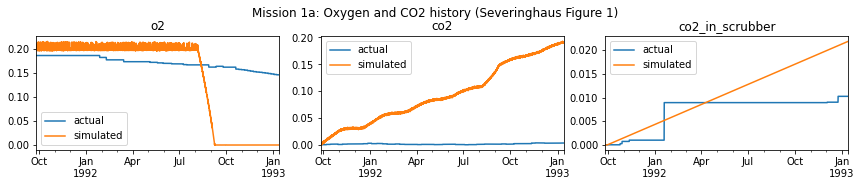

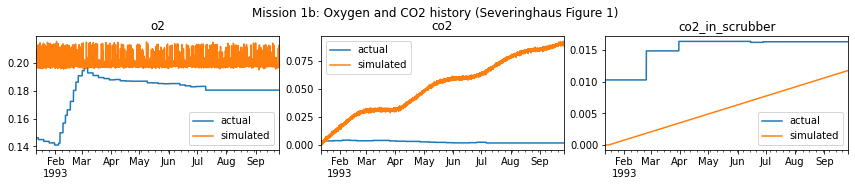

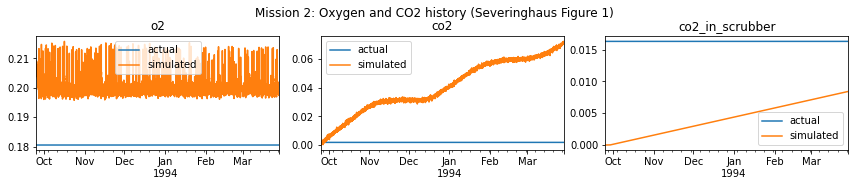

In [5]:
# Atmosphere
for mission in ('1a', '1b', '2'):
    start_date = {
        '1a': '1991-09-26',
        '1b': '1993-01-12',
        '2': '1993-09-25',
    }[mission]
    data = mission_data[mission]
    n_steps = len(data['b2_greenhouse']['age'])
    timesteps = pd.date_range(start_date, periods=n_steps, freq='H')
    def to_timesteps(df, value_col='percent'):
        """Return interpolated timestep values from a df of timestamped values"""
        ts = pd.DataFrame([], index=timesteps)  # Create a new df with timestep index
        for col in df.columns:
            ts[col] = df.loc[df.index[0], col]  # Fill with copies of the df[0]

        vals = ts[value_col].to_numpy()
        for i, row in df.iterrows():
            # Find the nearest timestep for every datapoint
            i_ts = ts.index.get_indexer([i], method='nearest')[0]
            # Set that step and all future steps to itself
            vals[i_ts:] = row[value_col]    
        ts[value_col] = vals
        return ts

    # 3-panel: o2, co2, co2 in scrubber
    fig, axs = plt.subplots(1, 3, figsize=(12, 2.5))
    fig.tight_layout(rect=[0, 0.03, 1, 0.9])
    fig.suptitle(f'Mission {mission}: Oxygen and CO2 history (Severinghaus Figure 1)')
    for i, field in enumerate(daily_o2_co2['label'].unique()):

        # Put the model data in a dataframe with a time axis
        if field == 'co2_in_scrubber':
            simulated = np.array(data['co2_storage']['storage']['co2'])
            # Divide by the total starting mass of b2_greenhouse for percentage
            greenhouse_atmosphere = sum([data['b2_greenhouse']['storage'][currency][0]
                                         for currency in data['b2_greenhouse']['storage']])
            simulated /= greenhouse_atmosphere
        else:
            simulated = np.array(data['b2_greenhouse']['storage_ratios'][field])
        # TODO: Convert kg ratio to mole ratio
        sim_ts = pd.DataFrame(simulated, index=timesteps, columns=['percent'])
        sim_ts['label'] = 'simulated'

        # Select sample data for mission
        actual = daily_o2_co2[daily_o2_co2['label'] == field]
        actual = actual[actual.index <= timesteps[-1]]  # Set range
        act_raw = pd.DataFrame(actual['value'].to_numpy(), 
                               index=actual.index, columns=['percent'])
        act_raw['label'] = 'actual'
        act_ts = to_timesteps(act_raw)

        # Plot both on the axis
        df = pd.concat([sim_ts, act_ts], axis=0)
        df.groupby('label').percent.plot(legend=True, title=field, ax=axs[i])

In [15]:
from agent_model.util import parse_data

# Aggregate gas flows
actual = pd.DataFrame(aggregate_flows['description'])
kg_per_kmole = 1000
actual['o2'] = aggregate_flows['o2_kmoles'] * kg_per_kmole
actual['co2'] = aggregate_flows['co2_kmoles'] * kg_per_kmole
# Reference variable is for 620 days. This is equivalent to
# Mission 1a (474 days) + the first 146 days of Mission 1b.
n_days = 620
mission_1b_cutoff_day = 146
print(f'Aggregate Gas Flows, Mission 1a + Mission 1b thru day '
      f'{mission_1b_cutoff_day} ({n_days} days, Severinghaus Table 1)\n')

# 'Air added on day 75' (ignore)
# 'Air dumped on day 474' (ignore)
# 'Pure O2 added on days 475-494'
#   Equivalent to 'the first 19 days of Mission 1b'
n_steps = 19 * 24
path = ['o2_makeup_valve', 'flows', 'o2', f'0:{n_steps}']
total_o2_added = sum(parse_data(mission_data['1b'], path))
print('Pure O2 added on days 475-494', 
      '\t| Actual:', actual.loc[2, 'o2'],
      '\t| Simulated:', round(total_o2_added, 2))

# 'Total CO2 taken up by scrubber'
#   Equivalent to the ending co2_storage.storage.co2 value
#   plus the same value in mission 1b at the cutoff day.
path = ['co2_storage', 'storage', 'co2', '*']
mission_1a_scrubbed = parse_data(mission_data['1a'], path)[-1]
path[3] = mission_1b_cutoff_day
mission_1b_scrubbed = parse_data(mission_data['1b'], path)
print('Total CO2 taken up by scrubber', 
      '\t| Actual:', actual.loc[3, 'co2'],
      '\t| Simulated:', -round(mission_1a_scrubbed + mission_1b_scrubbed, 2))

# 'Estimated net leakage' ('ignore')
# 'Soil Respiration'
#   The sum of all o2 and co2 values for soil
path = ['soil', 'flows', 'o2,co2', '*']
mission_1a_respiration = parse_data(mission_data['1a'], path)
path[3] = f'0:{mission_1b_cutoff_day}'
mission_1b_respiration = parse_data(mission_data['1b'], path)
respiration = {k: v + mission_1b_respiration[k] 
               for k, v in mission_1a_respiration.items()}
respiration = {k: round(sum(v), 2) for k, v in respiration.items()}
print('Soil Respiration O2\t', 
      '\t| Actual:', actual.loc[5, 'o2'],
      '\t| Simulated:', -round(respiration['o2'], 2))
print('Soil Respiration CO2\t', 
      '\t| Actual:', actual.loc[5, 'co2'],
      '\t| Simulated:', round(respiration['co2'], 2))

# 'Concrete Calcification'
path = ['concrete', 'flows', 'co2', '*']
mission_1a_concrete = sum(parse_data(mission_data['1a'], path))
path[3] = f'0:{mission_1b_cutoff_day}'
mission_1b_concrete = sum(parse_data(mission_data['1b'], path))
print('Concrete Calcification CO2', 
      '\t| Actual:', actual.loc[6, 'co2'],
      '\t| Simulated:', -round(mission_1a_concrete + mission_1b_concrete, 2))

Aggregate Gas Flows, Mission 1a + Mission 1b thru day 146 (620 days, Severinghaus Table 1)

Pure O2 added on days 475-494 	| Actual: 441000 	| Simulated: 25725.0
Total CO2 taken up by scrubber 	| Actual: -98000 	| Simulated: -967.22
Soil Respiration O2	 	| Actual: -708000 	| Simulated: -694976.83
Soil Respiration CO2	 	| Actual: 662000 	| Simulated: 656367.01
Concrete Calcification CO2 	| Actual: -550000 	| Simulated: -581955.65


Total Greenhouse Area: 1468


Text(0.5, 1.0, 'Greenhouse Layout')

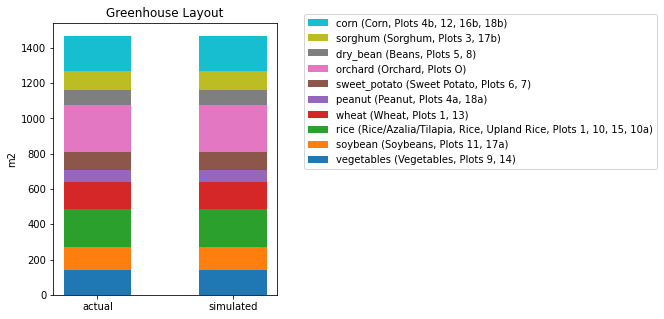

In [7]:
# Greenhouse layout

# The B2 mission greenhouse plots mapped to SIMOC agents and areas
greenhouse_reference = [
    # SIMOC agent, Mission 2 Area, B2 Reference, B2 Plots
    ('rice', 69 + 89 + 15 + 42, 'Rice/Azalia/Tilapia, Rice, Upland Rice', '1, 10, 15, 10a'),
    ('wheat', 56 + 94, 'Wheat', '1, 13'),
    ('sorghum', 55 + 51, 'Sorghum', '3, 17b'),
    ('peanut', 22 + 46, 'Peanut', '4a, 18a'),
    ('corn', 23 + 88 + 41 + 46, 'Corn', '4b, 12, 16b, 18b'),
    ('dry_bean', 40 + 50, 'Beans', '5, 8'),
    ('sweet_potato', 52 + 54, 'Sweet Potato', '6, 7'),
    ('vegetables', 60 + 81, 'Vegetables', '9, 14'),
    ('soybean', 81 + 51, 'Soybeans', '11, 17a'),
    ('orchard', 262, 'Orchard', 'O')
]
print('Total Greenhouse Area:', sum(p[1] for p in greenhouse_reference))

actual = {ref[0]: ref[1] for ref in greenhouse_reference}
simulated = {a: d['full_amount'] for a, d in mission_data['2'].items() 
             if 'growth' in d}
all_crops = set(actual.keys())
all_crops.update(set(simulated.keys()))
all_crops = list(all_crops)

fig, ax = plt.subplots(figsize=(4, 5))
labels = ['actual', 'simulated']
bottom = np.array([0, 0])
for i, crop in enumerate(all_crops):
    _actual = actual.get(crop, 0)
    _simulated = simulated.get(crop, 0)
    values = np.array([_actual, _simulated])
    ref = [p for p in greenhouse_reference if p[0] == crop][0]
    label = f'{crop} ({ref[2]}, Plots {ref[3]})'
    ax.bar(labels, values, label=label, bottom=bottom, width=0.5, align='center')
    bottom += values
    
# Need to reverse the axis for some reason
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('m2')
ax.set_title('Greenhouse Layout')

In [16]:
actual = production_rates.copy()        

simulated = pd.DataFrame(mission_data.keys(), columns=['mission'])
simulated.head()
productivity_crops = ('wheat', 'rice', 'corn', 'sorghum')

n_steps = {'1a': 11400, '1b': 6168, '2': 4440}

for crop in productivity_crops:
    crop_values = []
    path = [crop, 'flows', crop, '*']
    for i, (mission, simdata) in enumerate(mission_data.items()):
        if crop not in simdata:
            value = 0
        else:
            production = parse_data(simdata, path)
            value = sum(production) / simdata[crop]['full_amount']
            value /= n_steps[mission]
        crop_values.append(value)
    simulated[crop] = crop_values

print('Plant Productivity, kg/m2-day (Marino Table 3)\n')
print('Actual:')
print(actual.head())
print('\nSimulated:')
print(simulated.head())

Plant Productivity, kg/m2-day (Marino Table 3)

Actual:
  mission   wheat    rice    corn  sorghum
0      1a  0.0017  0.0023  0.0000   0.0017
1      1b  0.0012  0.0016  0.0000   0.0016
2       2  0.0030  0.0060  0.0039   0.0038

Simulated:
  mission     wheat      rice      corn   sorghum
0      1a  0.024195  0.011811  0.011811  0.024195
1      1b  0.026831  0.008907  0.008907  0.026831
2       2  0.024849  0.012131  0.012131  0.024849


In [10]:
%matplotlib inline
wheat_growth = mission_data['1a']['wheat']['flows']['wheat']
plt.plot(range(len(wheat_growth)), wheat_growth)

<Figure size 432x288 with 1 Axes>


In [ ]:
depr = mission_data['1a']['water_storage']['storage']['potable']
plt.plot(range(len(depr)), depr)


In [ ]:
for mission, simdata in mission_data.items():
    print(mission, simdata['b2_greenhouse'])

In [ ]:
mission_data.keys()

In [ ]:
production_rates